<a href="https://colab.research.google.com/github/ShubhankarKG/RUL_Prediction_SVM/blob/master/SVM_RUL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np #import cupy as np
import math
import matplotlib.pyplot as plt
from os import path

%matplotlib inline

In [2]:
def gen_rms(col):
  return np.squeeze(np.sqrt(np.mean(np.sum(col ** 2))))

In [3]:
base_path = "PRONOSTIA"
rms_horizontal = []

In [4]:
from IPython.display import ProgressBar

def assign_files(extension, files, base_path="PRONOSTIA/Learning_set") :
  rms_horizontal_local = []
  for i in range(files):
    file = base_path + extension + f"/acc_{str(i+1).zfill(5)}.csv"
    if path.exists(file):
      temp_df = pd.read_csv(file, header=None)
      temp_rms = gen_rms(temp_df[4])
      rms_horizontal_local.append(temp_rms)
  return rms_horizontal_local

In [5]:
rms_1_1 = assign_files("/Bearing1_1", 3269)

In [7]:
rms_1_2 = assign_files("/Bearing1_2", 1015)

In [8]:
rms_2_1 = assign_files("/Bearing2_1", 1062)

In [9]:
rms_2_2 = assign_files("/Bearing2_2", 797)

In [10]:
rms_3_1 = assign_files("/Bearing3_1", 604)

In [11]:
rms_3_2 = assign_files("/Bearing3_2", 1637)

In [12]:
import itertools

rms_1 = list(itertools.chain(rms_1_1, rms_1_2))
rms_2 = list(itertools.chain(rms_2_1, rms_2_2))
rms_3 = list(itertools.chain(rms_3_1, rms_3_2))


In [13]:
len(rms_1)

3674

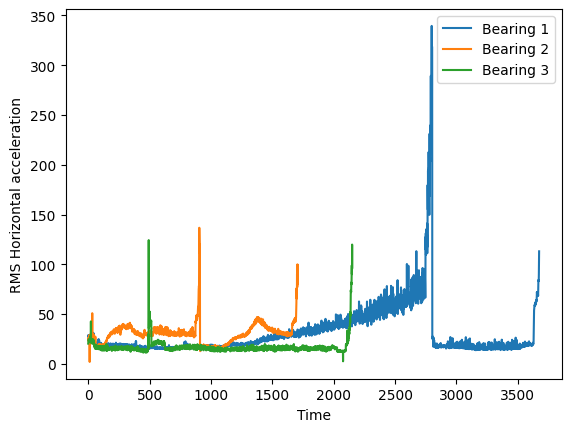

In [14]:
plt.figure()

temp1, = plt.plot([i for i in range(len(rms_1))], rms_1)
temp2, = plt.plot([i for i in range(len(rms_2))], rms_2)
temp3, = plt.plot([i for i in range(len(rms_3))], rms_3)
plt.xlabel('Time')
plt.ylabel('RMS Horizontal acceleration')
plt.legend([temp1, temp2, temp3], [
            "Bearing 1", "Bearing 2", "Bearing 3"])
plt.show()

In [15]:
rms_horizontal = list(itertools.chain(rms_1, rms_2, rms_3))

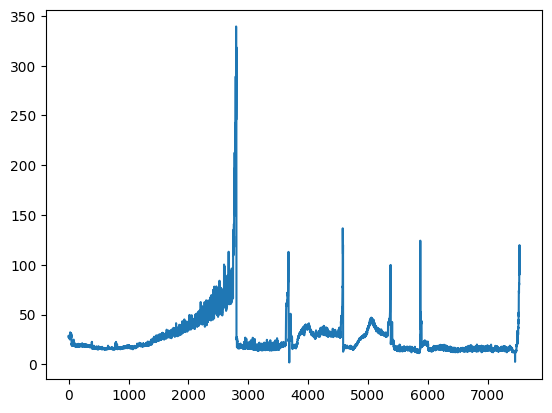

In [16]:
plt.figure()
plt.plot([i for i in range(len(rms_horizontal))], rms_horizontal)
plt.show()

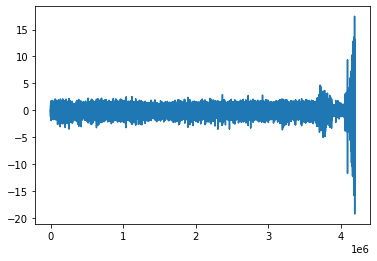

In [ ]:
#Plot de vibracion en eje x
#plt.figure()
#plt.plot([i for i in range(df_3_2.shape[0])], df_3_2["E"])
#plt.show()

In [17]:
def rrms(rms):
  stable_data_point = 250
  rms_np = np.array(rms)
  rms_norm = np.mean(rms_np[:stable_data_point])
  return rms_np / rms_norm

In [18]:
rrms_1_1 = rrms(rms_1_1)
rrms_1_2 = rrms(rms_1_2)
rrms_2_1 = rrms(rms_2_1)
rrms_2_2 = rrms(rms_2_2)
rrms_3_1 = rrms(rms_3_1)
rrms_3_2 = rrms(rms_3_2)

In [19]:
rrms_2_1 = rrms(rms_2_1)
rrms_3_1 = rrms(rms_3_1)

In [20]:
rrms_1 = rrms(rms_1)

In [21]:
rrms_2 = rrms(rms_2)

In [22]:
rrms_2_1 = rrms(rms_2_1)

In [23]:
rrms_3 = rrms(rms_3)

In [24]:
rrms_3_1 = rrms(rms_3_1)

In [25]:
len(rrms_1)

3674

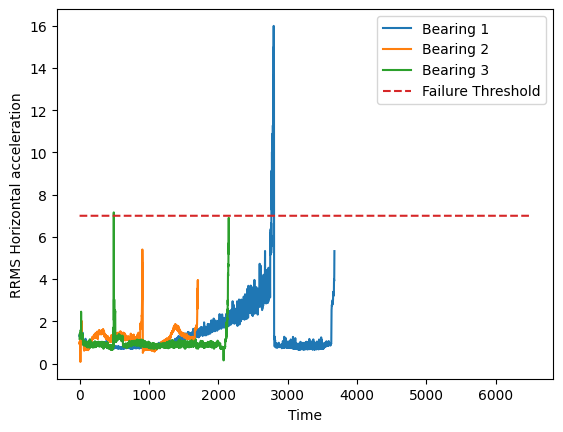

In [26]:
plt.figure()

temp1, = plt.plot([i for i in range(len(rrms_1))], list(rrms_1))
temp2, = plt.plot([i for i in range(len(rrms_2))], list(rrms_2))
temp3, = plt.plot([i for i in range(len(rrms_3))], list(rrms_3))
temp4, = plt.plot([i for i in range(6500)], [7 for i in range(6500)], '--')
plt.xlabel('Time')
plt.ylabel('RRMS Horizontal acceleration')
plt.legend([temp1, temp2, temp3, temp4], [
            "Bearing 1", "Bearing 2", "Bearing 3", "Failure Threshold"])
plt.show()

In [27]:
def irrms(rrms, window_length):
  rrms_np = np.array(rrms)
  irrms = []

  x = [10*i for i in range(len(rrms))]

  y = np.array([np.mean(rrms[i: i+window_length]) for i in range(len(rrms) - window_length)])


  for i in range(len(rrms) - window_length):

    x_range = np.array(x[i: i+window_length])
    # y_range = np.array(y[i: i+window_length])
    y_range = np.array([np.mean(rrms[i: i+window_length]) for _ in range(window_length)])
    k_num = np.sum(np.dot(x_range, y_range)) -( np.sum(x_range) * np.sum(y_range) )/window_length
    k_denom = np.sum(x_range ** 2) - (np.sum(x_range) ** 2) / window_length

    k = k_num / k_denom

    b = (np.sum(y_range) - k * np.sum(x_range)) / window_length

    rrms_d = []
    for j in range(window_length):
      rrms_d.append(rrms[i+j] - k*x[i+j] - b)

    rrms_d_np = np.array(rrms_d)
    mu = np.mean(rrms_d_np)
    sigma = np.sqrt(np.mean((rrms_d_np - mu) ** 2))
    
    min_rrms_d = mu - 3*sigma
    max_rrms_d = mu + 3*sigma
    rrms_d_i = rrms[i] - k*x[i] - b
    if rrms_d_i <= min_rrms_d:
      temp_irrms = np.mean(rrms_np[i: i+window_length])
    elif rrms_d_i > min_rrms_d and rrms_d_i < max_rrms_d:
      temp_irrms = k * x[i] + b
    elif rrms_d_i >= max_rrms_d:
      temp_irrms = k * x[i] + b + max_rrms_d
    irrms.append(temp_irrms)
  return irrms

In [28]:
window_length = 30

In [29]:
irrms_1 = irrms(rrms_1, window_length)

In [30]:
irrms_2_1 = irrms(rrms_2_1, window_length)
irrms_3_1 = irrms(rrms_3_1, window_length)

In [31]:
irrms_1_1 = irrms(rrms_1_1, window_length)
irrms_1_2 = irrms(rrms_1_2, window_length)
irrms_2_2 = irrms(rrms_2_2, window_length)
irrms_3_2 = irrms(rrms_3_2, window_length)

In [32]:
irrms_2 = irrms(rrms_2, window_length)

In [33]:
irrms_3 = irrms(rrms_3, window_length)

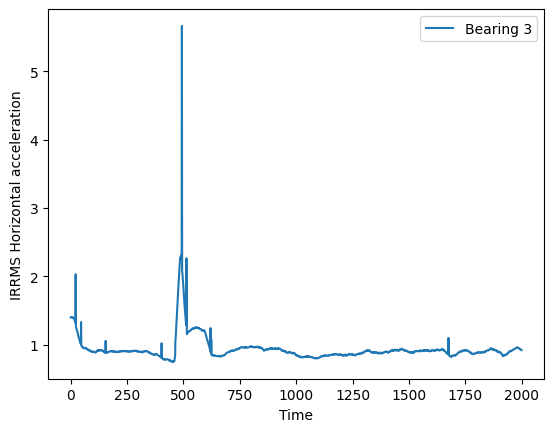

In [34]:
plt.figure()
temp3, = plt.plot([i for i in range(len(irrms_3[:2000]))], list(irrms_3[:2000]))
plt.xlabel('Time')
plt.ylabel('IRRMS Horizontal acceleration')
plt.legend([ temp3], [ "Bearing 3"])
plt.show()

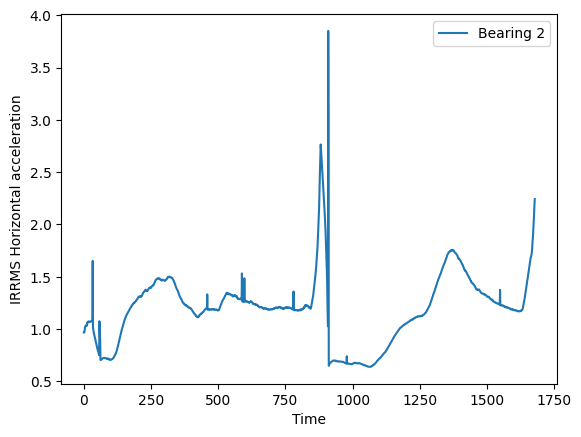

In [35]:
plt.figure()
temp, = plt.plot([i for i in range(len(irrms_2[:2000]))], list(irrms_2[:2000]))
plt.xlabel('Time')
plt.ylabel('IRRMS Horizontal acceleration')
plt.legend([ temp], [ "Bearing 2"])
plt.show()

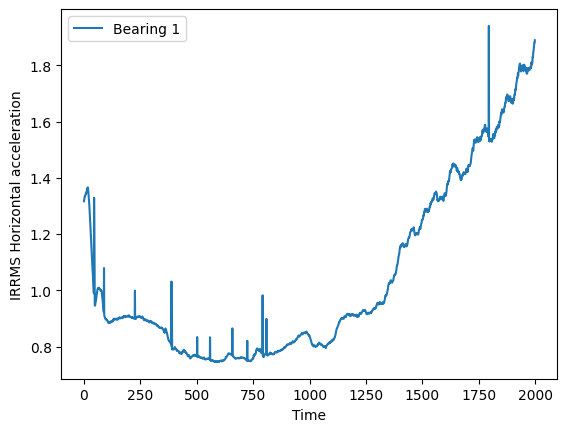

In [36]:
plt.figure()
temp3, = plt.plot([i for i in range(len(irrms_1[:2000]))], list(irrms_1[:2000]))
plt.xlabel('Time')
plt.ylabel('IRRMS Horizontal acceleration')
plt.legend([ temp3], [ "Bearing 1"])
plt.show()

In [37]:
# import random

# W = 0.5
# c1 = 0.8
# c2 = 0.9

# class Particle():
#   def __init__(self):
#     self.position = np.array([random.uniform(0, 2), random.uniform(1e-95, 1e-85), random.uniform(20, 30), random.randrange(200)*10])
#     self.pbest_position = self.position
#     self.pbest_value = float('inf')
#     self.velocity = np.array([0,0,0,0])
  
#   def move(self):
#     self.poition = self.position + self.velocity

# class Space():
#   def __init__(self, target, target_error, n_particles):
#     self.target = target
#     self.target_error = target_error
#     self.n_particles = n_particles
#     self.particles = []
#     self.gbest_value = float('inf')
#     self.gbest_position = np.array([random.uniform(0, 2), random.uniform(1e-95, 1e-85), random.uniform(20, 30), random.randrange(200)*10])
  
#   def fitness(self, particle):
#     return particle.position[0] + particle.position[1]*pow(particle.position[3], particle.position[2])
  
#   def set_pbest(self):
#     for particle in self.particles:
#       fitness_candidate = self.fitness(particle)
#       if(particle.pbest_value > fitness_candidate):
#         particle.pbest_value = fitness_candidate
#         particle.pbest_position = particle.position
  
#   def set_gbest(self):
#     for particle in self.particles:
#       best_fitness_candidate = self.fitness(particle)
#       if(self.gbest_value > best_fitness_candidate):
#         self.gbest_value = best_fitness_candidate
#         self.gbest_position = particle.position
  
#   def move_particles(self):
#     for particle in self.particles:
#       new_velocity = (W*particle.velocity) + (c1*random.random()) * (particle.pbest_position - particle.position) + (c2*random.random()) * (self.gbest_position - particle.position)
#       particle.velocity = new_velocity
#       particle.move()

# search_space = Space(1, 1e-6, 100)
# particles_vector = [Particle() for _ in range(search_space.n_particles)]
# search_space.particles = particles_vector

# for i in range(100):
#   search_space.set_pbest()
#   search_space.set_gbest()
#   if(abs(search_space.gbest_value - search_space.target) <= search_space.target_error):
#     break

#   search_space.move_particles()
# print("The best values are", search_space.gbest_position)

In [38]:
def fit_values(k, b, Y, M, B, rrms):
  y_array = []
  x = []
  for i in range(len(rrms)):
    x.append(i)
    y = Y + M*pow(i,B)
    if(y < 1.1):
      y = k * x[i] + b
    y_array.append(y)
  return y_array, x

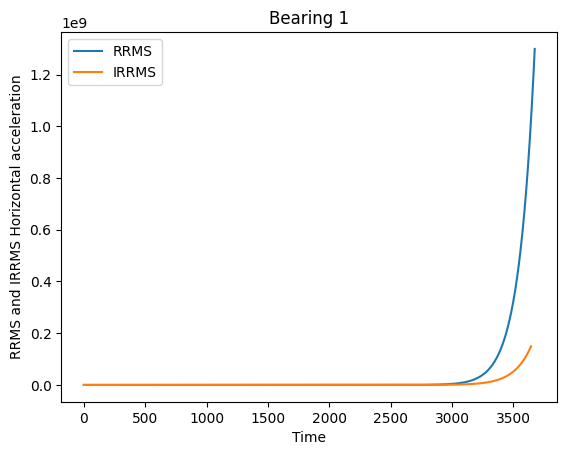

In [39]:
y_rrms_array_1, x = fit_values(2.31e-5, 0.99, 1.10, 1.68e-93, 28.58, rrms_1)
temp1, = plt.plot(x, y_rrms_array_1)
y_irrms_array_1, x = fit_values(2.41e-5, 1.01, 1.08, 3.22e-86, 26.30, irrms_1)
temp2, = plt.plot(x, y_irrms_array_1)
plt.xlabel('Time')
plt.ylabel('RRMS and IRRMS Horizontal acceleration')
plt.title("Bearing 1")
plt.legend([temp1, temp2], [
            "RRMS", "IRRMS"])
plt.show()

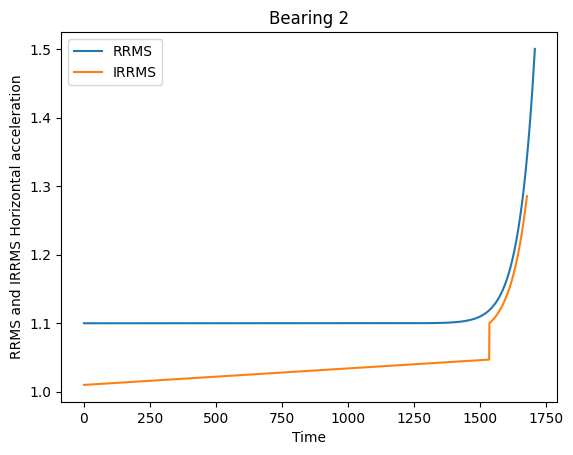

In [40]:
y_rrms_array_2, x = fit_values(2.31e-5, 0.99, 1.10, 1.68e-93, 28.58, rrms_2)
temp1, = plt.plot(x, y_rrms_array_2)
y_irrms_array_2, x = fit_values(2.41e-5, 1.01, 1.08, 3.22e-86, 26.30, irrms_2)
temp2, = plt.plot(x, y_irrms_array_2)
plt.xlabel('Time')
plt.ylabel('RRMS and IRRMS Horizontal acceleration')
plt.title("Bearing 2")
plt.legend([temp1, temp2], [
            "RRMS", "IRRMS"])
plt.show()

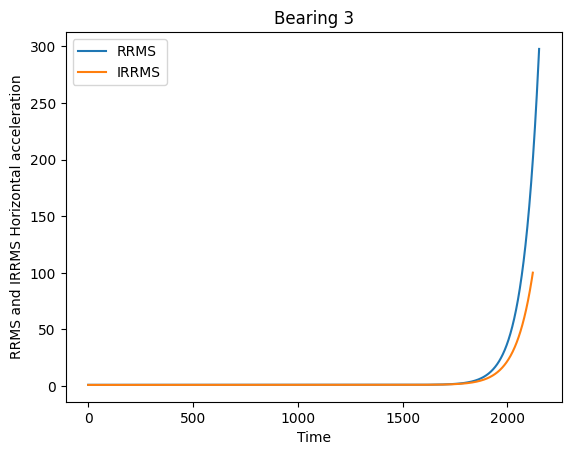

In [41]:
y_rrms_array_3, x = fit_values(2.31e-5, 0.99, 1.10, 1.68e-93, 28.58, rrms_3)
temp1, = plt.plot(x, y_rrms_array_3)
y_irrms_array_3, x = fit_values(2.41e-5, 1.01, 1.08, 3.22e-86, 26.30, irrms_3)
temp2, = plt.plot(x, y_irrms_array_3)
plt.xlabel('Time')
plt.ylabel('RRMS and IRRMS Horizontal acceleration')
plt.title("Bearing 3")
plt.legend([temp1, temp2], [
            "RRMS", "IRRMS"])
plt.show()

In [42]:
class_irrms = []

RRMS_THRESHOLD = 1.2

In [43]:
def generate_svm_data(rrms, irrms, rrms_threshold=1.1):
  output_data = []

  # Don't consider the first window_size elements (as they are missing in irrms as well).
  rrms = rrms[30:]

  # Find the degradation index from the reversed list (or form the back side of the list).
  deg_rev_idx = next(x for x, val in enumerate(reversed(rrms)) if val < rrms_threshold)
  deg_idx = len(rrms) - deg_rev_idx

  deg_time = deg_idx * 10

  for i in range(deg_idx):
    output_data.append(0)
  for i in range(deg_idx, len(rrms)):
    if i < deg_idx + int(deg_rev_idx * 0.6):
      output_data.append(1)
    elif i < deg_idx + int(deg_rev_idx * 0.8):
      output_data.append(2)
    elif i < deg_idx + int(deg_rev_idx * 0.95):
      output_data.append(3)
    else:
      output_data.append(4)

  input_data = np.c_[np.array(rrms), np.array(irrms)]

  edge_data = []
  for i in set(output_data):
    idx = output_data.index(i)
    edge_data.append(input_data.tolist()[idx][1])

  # Remove the first edge for class 0, do not require that.
  edge_data = edge_data[1:]
  
  # Add the edge of the last data point.
  edge_data.append(input_data.tolist()[-1][1])
  
  temp = []
  # In the form [[edge_1, edge_2], [edge_2, edge_3] ...]
  for i, v in enumerate(edge_data):
    if i+1 < len(edge_data):
      temp.append([v, edge_data[i+1]])

  edge_data = temp
  output_data = np.array(output_data)
  
  return input_data, output_data, edge_data, deg_time

In [44]:
input_2_1, output_2_1, edge_2_1, deg_time_2_1 = generate_svm_data(rrms_2_1, irrms_2_1)
input_3_1, output_3_1, edge_3_1, deg_time_3_1 = generate_svm_data(rrms_3_1, irrms_3_1)

print(deg_time_2_1, deg_time_3_1)

8360 4630


In [45]:
input_1_1, output_1_1, edge_time_1_1, deg_time_1_1 = generate_svm_data(rrms_1_1, irrms_1_1)
input_1_2, output_1_2, edge_time_1_2, deg_time_1_2 = generate_svm_data(rrms_1_2, irrms_1_2)
input_2_2, output_2_2, edge_time_2_1, deg_time_2_1 = generate_svm_data(rrms_2_2, irrms_2_2)
input_3_2, output_3_2, edge_time_2_2, deg_time_2_2 = generate_svm_data(rrms_3_2, irrms_3_2)

In [46]:
class SVM:
    '''
    This SVM model uses stochastic gradient decsent for optimisation.
    '''

    def predict(self, input_data):
        '''
        Returns
        -------
        ndarray
            The classes of data according to the sign of X.W
        '''
        return np.sign(
            np.dot(
                np.c_[np.ones(input_data.shape[0]), input_data],
                self.W
            )
        )

    def _cost(self):
        '''
        Hingle loss with l2 regularisation
        '''
        m = self.X.shape[0]
        hinge_loss = self.C * \
            (1 - np.multiply(self.Y, np.dot(self.X, self.W)))/m
        return -np.mean(1/2 * np.dot(self.W.T, self.W) + hinge_loss)

    def _calculate_gradient(self):
        '''
        gradient = W if y_i * (x_i).(W) >= 1
        gradient = W - (C * y_i)x_i otherwise
        '''
        distance = 1 - (self.Y * np.dot(self.X, self.W))
        dW = np.zeros(self.W.shape[0]).reshape(-1, 1)

        for idx, d in enumerate(distance):
            if max(0, d) == 0:
                di = self.W
            else:
                c = (self.C * self.Y[idx]) * self.X[idx]
                c = c.reshape(-1, 1)
                di = self.W - c
            dW += di

        return dW/(self.Y.shape[0])

    def fit(self, input_data, output_data, lr, C, max_epochs=1000, plot_loss=False):
        '''
        Fit the model using Stochastic gradient descent


        Parameters
        ----------
        input_data : ndarray
            The features of the data.

        output_data : ndarray
            True class labels, should be -1 and 1 (not 0 and 1).

        lr : int
            Learning rate

        C : int
            Regularisation parameter

        max_epochs : int, default=1000
            Max iterations for SGD

        plot_loss : boolean, default=False
            Plot the cost vs epoch graph


        Returns
        -------
        SVM
            The model itself
        '''
        self.X = np.c_[np.ones(input_data.shape[0]), input_data]
        self.Y = np.array(output_data).reshape(-1, 1)
        self.C = C
        self.W = np.zeros(self.X.shape[1]).reshape(-1, 1)

        total_loss = []

        for epoch in range(max_epochs):
            self.W = self.W - lr * self._calculate_gradient()
            if plot_loss:
                total_loss.append(self._cost())

        if plot_loss:
            plt.plot(total_loss)
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Cost')

        return self

In [47]:
class OneVsRest:
  def __init__(self, input_data, output_data):
    self.models = [SVM() for i in set(output_data)]
    self.x = input_data
    self.y = output_data
  
  def fit(self, lr, C, max_epochs=1000, plot_loss=False):
    trained_models = []
    for idx, model in enumerate(self.models):
      output = []
      for y in self.y:
        if y == idx:
          output.append(1)
        else:
          output.append(-1)
      
      in_data = np.array(self.x)
      out_data = np.array(output)
      trained_models.append(model.fit(in_data, out_data, lr, C, max_epochs, plot_loss))

    self.models = trained_models
    return trained_models

  def predict(self, input_data):
    pred = []
    for model in self.models:
      pred.append(model.predict(input_data))
    pred = np.array(pred)
    return np.argmax(pred, axis=0)

In [48]:
class OneVsOne:
  def __init__(self, input_data, output_data):
    self.n_classes = len(set(output_data))
    n_models = int(self.n_classes * (self.n_classes - 1) * 0.5) # nC2 for pairs of classes
    self.models = [SVM() for i in range(n_models)]

    self.indices = []
    for i in range(self.n_classes):
      for j in range(i+1, self.n_classes):
        self.indices.append([i, j])

    self.x = input_data
    self.y = output_data
  
  def fit(self, lr, C, max_epochs=1000, plot_loss=False):
    trained_models = []
    N = len(self.models)
    df = np.c_[np.array(self.x), np.array(self.y)]

    for model, index in zip(self.models, self.indices):
      outp = []
      inp = []
      for x in df.tolist():
        if x[-1] == index[0]:
          temp = x[:-1]
          inp.append(temp)
          outp.append(1)
        elif x[-1] == index[1]:
          temp = x[:-1]
          inp.append(temp)
          outp.append(-1)

      in_data = np.array(inp)
      out_data = np.array(outp)
      trained_models.append(model.fit(in_data, out_data, lr, C, max_epochs, plot_loss))

    self.models = trained_models
    return trained_models

  def predict(self, input_data):
    pred = []
    for model in self.models:
      pred.append(model.predict(input_data))
    pred = np.array(pred)
    return np.argmax(pred, axis=0)


In [49]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

input_2_1 = MinMaxScaler().fit_transform(input_2_1.tolist())
input_3_1 = MinMaxScaler().fit_transform(input_3_1.tolist())

In [50]:
model = SVC(decision_function_shape='ovo').fit(input_3_1, output_3_1.tolist())
model.predict(input_2_1)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,

In [51]:
def hybrid_degradation(k, lp, sts, irrmsj, irrmsj1, irrms_edges):
  si = 6
  k0 = 0.0005
  sts = int(sts)
  if k <= k0:
    for sm in range(si):
      lp[sts] = (lp[sts] + lp[sts-1])/2
  elif k > k0:
    lp[sts] = (irrmsj - irrmsj1) * (lp[sts] - lp[sts-1])
    lp[sts] = lp[sts]/(irrms_edges[sts][1] - irrms_edges[sts][0])
    lp[sts] = lp[sts] + lp[sts - 1]
  return lp

In [52]:
lp = [0, 0.60, 0.80, 0.95, 1.0]
x = [i for i in range(len(irrms_2_1))]
k = 0
for i in range(len(irrms_2_1) - window_length):
  x_range = np.array(x[i: i+window_length])
  y_range = np.array([np.mean(np.array(irrms_2_1[i: i+window_length])) for _ in range(window_length)])
  k_num = np.sum(np.dot(x_range, y_range)) -( np.sum(x_range) * np.sum(y_range) )/window_length
  k_denom = np.sum(x_range ** 2) - (np.sum(x_range) ** 2) / window_length
  k = k_num / k_denom

  if i > 0:
    hybrid_degradation(k, lp, output_2_1[i], irrms_2_1[i], irrms_2_1[i-1], edge_2_1)
print(lp)

[1.0, 1.0, 0.8, 0.95, 1.0]


In [53]:
def predict_rul(input_data, deg_time, lp):
  rul_pred = []
  rul_pred_total = []
  pred_classes = model.predict(input_data)
  for idx, val in enumerate(pred_classes):
    if val > 0:
      rul_pred.append(deg_time + ((idx * 10) - deg_time)/lp[val] - (idx*10))
      rul_pred_total.append(deg_time + ((idx * 10) - deg_time)/lp[val])
    else:
      rul_pred.append(0)
      rul_pred_total.append(0)
  return rul_pred, rul_pred_total

In [54]:
rul_remaining, rul_full = predict_rul(input_3_1, deg_time_3_1, [0, 0.60, 0.80, 0.95,1.0])

In [55]:
actual_rul = len(input_3_1) * 10 - 10

actual_rul

4840

In [56]:
# Find out all non zero values from predicted output and find mean
rul_full_non_zero = []
for i in rul_full:
  if i != 0:
    rul_full_non_zero.append(i)

pred_rul = np.mean(np.array(rul_full_non_zero))

In [57]:
pred_rul

4766.997607655502

In [58]:
def error_rate(actual, pred):
  return abs(((actual - pred) / actual) * 100)

In [59]:
error_rate(actual_rul, pred_rul)

1.5083138914152443